<h1 style="font-size:50px;" align="center">Inferencia Bayesiana usando el Motor de Inferencia MIB</h1>

<h1 style="font-size:30px;" align="center">Quien escribió este cuento</h1>

In [ ]:
!apt-get install subversion
!svn checkout "https://github.com/abrilrys/Proyecto_IA"

Reading package lists... Done
Building dependency tree       
Reading state information... Done
subversion is already the newest version (1.9.7-4ubuntu1.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.
Checked out revision 1.


In [ ]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import glob
import nltk

nltk.download('punkt')
from nltk.tokenize import word_tokenize

from collections import Counter #regresa un diccionario con conteos
from collections import OrderedDict #diccionarios ordenados
from itertools import product,islice   #calcula producto cartesiano y saca una rebanada de diccionario


import mib as mb
import tpproc as tp

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
archivos = glob.glob('Proyecto_IA/trunk/Train/*/*')
archivos,nombres = tp.carga_cuentos(archivos)
df_train = tp.lee_cuentos(archivos,stw=True, remove_punkt=True)
df_train.head()

leyendo...
tamaño del contenido de archivos cargados:             10 KB


,titulo,tipo,autor,texto
0,el almohadón de plumas,cuento,horacio quiroga,luna miel largo escalofrío rubia angelical tím...
1,el vampiro,cuento,horacio quiroga,dijo abogado rhode causa caso bastante raro aq...
2,desquite,cuento,josé saramago,muchacho venía río descalzo pantalones arreman...
3,café en suspenso,minicuento,josé saramago,nápoles existe costumbre mandar traer café pag...
4,acuérdate,cuento,juan rulfo,acuérdate urbano gómez hijo don urbano nieto d...


In [ ]:
archivos = glob.glob('Proyecto_IA/trunk/Test/*')
archivos,nombres = tp.carga_cuentos(archivos)
df_test = tp.lee_cuentos(archivos, test=True,stw=True, remove_punkt=True)
df_test.head()

leyendo...
tamaño del contenido de archivos cargados:             4 KB


,titulo,texto
0,la muerte,muerte cansada esperar viejo rabí casi centena...
1,la escopeta,noche cerrada estiré brazo encender lámpara me...
2,prisa,pesar torpor ojos hinchados aire recién salido...
3,el caballo y el lobo,estación blandos céfiros hacen verdear campos ...
4,los dos cazadores,cierto día mayo alegría tristeza encontraron o...


## Formateo de Data Frames de trabajo (paso a paso)

In [ ]:
df_train_T = df_train.copy()
df_test_T = df_test.copy()

In [ ]:
from collections import Counter  #regresa un diccionario con conteos

df_train_T['palabras']=df_train_T['texto'].apply(lambda x: x.split())
df_train_T['total']=df_train_T['palabras'].apply(lambda x: len(x))
df_train_T['conteos']=df_train_T['palabras'].apply(lambda x: Counter(x))

df_train_T=df_train_T.sort_values(by="total",ascending=False)
df_train_T.head()

# print(df_train_T)

,titulo,tipo,autor,texto,palabras,total,conteos
7,chac mool,cuento,carlos fuentes,hace tiempo filiberto murió ahogado acapulco s...,"[hace, tiempo, filiberto, murió, ahogado, acap...",1807,"{'hace': 5, 'tiempo': 4, 'filiberto': 10, 'mur..."
5,nos han dado la tierra,cuento,juan rulfo,después tantas horas caminar encontrar sombra ...,"[después, tantas, horas, caminar, encontrar, s...",685,"{'después': 3, 'tantas': 1, 'horas': 2, 'camin..."
0,el almohadón de plumas,cuento,horacio quiroga,luna miel largo escalofrío rubia angelical tím...,"[luna, miel, largo, escalofrío, rubia, angelic...",653,"{'luna': 1, 'miel': 1, 'largo': 6, 'escalofrío..."
18,la luz es como el agua,cuento,gabriel garcía márquez,navidad niños volvieron pedir bote remos acuer...,"[navidad, niños, volvieron, pedir, bote, remos...",564,"{'navidad': 1, 'niños': 7, 'volvieron': 1, 'pe..."
2,desquite,cuento,josé saramago,muchacho venía río descalzo pantalones arreman...,"[muchacho, venía, río, descalzo, pantalones, a...",512,"{'muchacho': 14, 'venía': 1, 'río': 7, 'descal..."


In [ ]:
df_train_T['conteos']=df_train_T['conteos'].apply(lambda x:{k: v for k, v in sorted(x.items(), key=lambda item: item[1],reverse=True)})
df_train_T.head()



,titulo,tipo,autor,texto,palabras,total,conteos
7,chac mool,cuento,carlos fuentes,hace tiempo filiberto murió ahogado acapulco s...,"[hace, tiempo, filiberto, murió, ahogado, acap...",1807,"{'chac': 32, 'mool': 28, 'agua': 11, 'filibert..."
5,nos han dado la tierra,cuento,juan rulfo,después tantas horas caminar encontrar sombra ...,"[después, tantas, horas, caminar, encontrar, s...",685,"{'llano': 13, 'tierra': 12, 'dice': 9, 'aquí':..."
0,el almohadón de plumas,cuento,horacio quiroga,luna miel largo escalofrío rubia angelical tím...,"[luna, miel, largo, escalofrío, rubia, angelic...",653,"{'alicia': 17, 'jordán': 16, 'día': 8, 'cama':..."
18,la luz es como el agua,cuento,gabriel garcía márquez,navidad niños volvieron pedir bote remos acuer...,"[navidad, niños, volvieron, pedir, bote, remos...",564,"{'bote': 9, 'dijo': 9, 'niños': 7, 'papá': 7, ..."
2,desquite,cuento,josé saramago,muchacho venía río descalzo pantalones arreman...,"[muchacho, venía, río, descalzo, pantalones, a...",512,"{'muchacho': 14, 'río': 7, 'hacia': 6, 'quedó'..."


In [ ]:
df_train_T['topw']=df_train_T['conteos'].apply(lambda x:list(x.keys())[:5])
df_train_T.head()

,titulo,tipo,autor,texto,palabras,total,conteos,topw
7,chac mool,cuento,carlos fuentes,hace tiempo filiberto murió ahogado acapulco s...,"[hace, tiempo, filiberto, murió, ahogado, acap...",1807,"{'chac': 32, 'mool': 28, 'agua': 11, 'filibert...","[chac, mool, agua, filiberto, hoy]"
5,nos han dado la tierra,cuento,juan rulfo,después tantas horas caminar encontrar sombra ...,"[después, tantas, horas, caminar, encontrar, s...",685,"{'llano': 13, 'tierra': 12, 'dice': 9, 'aquí':...","[llano, tierra, dice, aquí, pueblo]"
0,el almohadón de plumas,cuento,horacio quiroga,luna miel largo escalofrío rubia angelical tím...,"[luna, miel, largo, escalofrío, rubia, angelic...",653,"{'alicia': 17, 'jordán': 16, 'día': 8, 'cama':...","[alicia, jordán, día, cama, largo]"
18,la luz es como el agua,cuento,gabriel garcía márquez,navidad niños volvieron pedir bote remos acuer...,"[navidad, niños, volvieron, pedir, bote, remos...",564,"{'bote': 9, 'dijo': 9, 'niños': 7, 'papá': 7, ...","[bote, dijo, niños, papá, padres]"
2,desquite,cuento,josé saramago,muchacho venía río descalzo pantalones arreman...,"[muchacho, venía, río, descalzo, pantalones, a...",512,"{'muchacho': 14, 'río': 7, 'hacia': 6, 'quedó'...","[muchacho, río, hacia, quedó, agua]"


In [ ]:
top=5
df_train_T['topw']=df_train_T['conteos'].apply(lambda x:list({k: v for k, v in sorted(x.items(), key=lambda item: item[1],reverse=True)}.keys())[:top])
df_train_T.head()

,titulo,tipo,autor,texto,palabras,total,conteos,topw
7,chac mool,cuento,carlos fuentes,hace tiempo filiberto murió ahogado acapulco s...,"[hace, tiempo, filiberto, murió, ahogado, acap...",1807,"{'chac': 32, 'mool': 28, 'agua': 11, 'filibert...","[chac, mool, agua, filiberto, hoy]"
5,nos han dado la tierra,cuento,juan rulfo,después tantas horas caminar encontrar sombra ...,"[después, tantas, horas, caminar, encontrar, s...",685,"{'llano': 13, 'tierra': 12, 'dice': 9, 'aquí':...","[llano, tierra, dice, aquí, pueblo]"
0,el almohadón de plumas,cuento,horacio quiroga,luna miel largo escalofrío rubia angelical tím...,"[luna, miel, largo, escalofrío, rubia, angelic...",653,"{'alicia': 17, 'jordán': 16, 'día': 8, 'cama':...","[alicia, jordán, día, cama, largo]"
18,la luz es como el agua,cuento,gabriel garcía márquez,navidad niños volvieron pedir bote remos acuer...,"[navidad, niños, volvieron, pedir, bote, remos...",564,"{'bote': 9, 'dijo': 9, 'niños': 7, 'papá': 7, ...","[bote, dijo, niños, papá, padres]"
2,desquite,cuento,josé saramago,muchacho venía río descalzo pantalones arreman...,"[muchacho, venía, río, descalzo, pantalones, a...",512,"{'muchacho': 14, 'río': 7, 'hacia': 6, 'quedó'...","[muchacho, río, hacia, quedó, agua]"


## Todo en 1
### Data Frames de Trabajo
- **Se puede jugar con el parámetro _top_ para aumentar o reducir el vocabulario**
- Se crean diccionarios para indexar las palabras a valores numéricos

In [ ]:
df_train_T2= df_train_T.copy()
df_train_T = df_train.copy()
df_test_T = df_test.copy()

"""
Cambiar si se desea (y se puede) aumentar el vocabulario
"""
top=5

df_train_T['topw']=df_train_T['texto'].apply(lambda x:[w[0] for w in sorted(Counter(x.split()).items(), key=lambda item: item[1],reverse=True)[:top]])
df_test_T['topw']=df_test_T['texto'].apply(lambda x:[w[0] for w in sorted(Counter(x.split()).items(), key=lambda item: item[1],reverse=True)[:top]])

### Vocabulario de entrenamiento y prueba
vTR={}
vTS={}

# Obtenemos el vocabulario de entrenamiento
i=0
for l in df_train_T.topw.values:
    for w in l:
        if w not in vTR:
            vTR[w]=i
            i+=1
vTR['UNK']=i # Agregamos palabra desconocida 'UNK'
print(vTR)

print(len(vTR), 'palabras en vocabulario entrenamiento, incluyendo palabra desconocida (UNK)')

# Sustituimos palabra que no esta en vTR por palabra desconocida 'UNK' en textos de prueba
df_test_T['topw']=df_test_T['topw'].apply(lambda x:[w if w in vTR.keys() else 'UNK' for w in x])

# Obtenemos el vocabulario de prueba
i=0
for l in df_test_T.topw.values:
    for w in l:
        if w not in vTS: 
            vTS[w]=i
            i+=1

print(len(vTS), 'palabras en vocabulario de prueba, incluyendo palabra desconocida (UNK)')

df_tr= df_train_T.filter(['titulo','tipo','autor'], axis=1)
df_ts= df_test_T.filter(['titulo'], axis=1)
for i in range(top):
    df_tr['w{}'.format(i)]=''
for i in range(top):
    df_ts['w{}'.format(i)]=''

for i,row in enumerate(df_train_T.iterrows()):
    l=row[1]['topw']
    for j,w in enumerate(l):
        df_tr.iloc[i,df_tr.columns.get_loc('w{}'.format(j))]=w
for i,row in enumerate(df_test_T.iterrows()):
    l=row[1]['topw']
    for j,w in enumerate(l):
        df_ts.iloc[i,df_ts.columns.get_loc('w{}'.format(j))]=w
   
display(df_tr.head())
display(df_ts.head())


{'alicia': 0, 'jordán': 1, 'día': 2, 'cama': 3, 'largo': 4, 'entonces': 5, 'mujer': 6, 'maría': 7, 'ojos': 8, 'gata': 9, 'muchacho': 10, 'río': 11, 'hacia': 12, 'quedó': 13, 'agua': 14, 'café': 15, 'cuatro': 16, 'suspenso': 17, 'pobre': 18, 'nápoles': 19, 'acuérdate': 20, 'urbano': 21, 'después': 22, 'dos': 23, 'llano': 24, 'tierra': 25, 'dice': 26, 'aquí': 27, 'pueblo': 28, 'solo': 29, 'sirenas': 30, 'ulises': 31, 'vez': 32, 'cantaron': 33, 'chac': 34, 'mool': 35, 'filiberto': 36, 'hoy': 37, 'hierba': 38, 'dijo': 39, 'sombra': 40, 'árbol': 41, 'cierto': 42, 'vino': 43, 'vasija': 44, 'gobernador': 45, 'llegó': 46, 'príncipe': 47, 'hombre': 48, 'obispo': 49, 'lengua': 50, 'siervo': 51, 'poeta': 52, 'poema': 53, 'escrito': 54, 'años': 55, 'líneas': 56, 'filósofos': 57, 'fuente': 58, 'busco': 59, 'perro': 60, 'asno': 61, 'amo': 62, 'fin': 63, 'lobo': 64, 'cien': 65, 'júpiter': 66, 'alguacil': 67, 'buey': 68, 'casa': 69, 'amistad': 70, 'amigos': 71, 'noche': 72, 'dinero': 73, 'león': 74, '

,titulo,tipo,autor,w0,w1,w2,w3,w4
0,el almohadón de plumas,cuento,horacio quiroga,alicia,jordán,día,cama,largo
1,el vampiro,cuento,horacio quiroga,entonces,mujer,maría,ojos,gata
2,desquite,cuento,josé saramago,muchacho,río,hacia,quedó,agua
3,café en suspenso,minicuento,josé saramago,café,cuatro,suspenso,pobre,nápoles
4,acuérdate,cuento,juan rulfo,acuérdate,urbano,después,dos,entonces


,titulo,w0,w1,w2,w3,w4
0,la muerte,UNK,UNK,UNK,UNK,UNK
1,la escopeta,UNK,UNK,UNK,UNK,UNK
2,prisa,UNK,UNK,UNK,UNK,UNK
3,el caballo y el lobo,lobo,dijo,UNK,UNK,UNK
4,los dos cazadores,dos,UNK,UNK,UNK,UNK


## Preguntas

1. ¿Quién escribió "El caballo y el Lobo"?
2. "La escopeta" ¿es una fábula?
3. ¿Qué probabilidad hay de que "La muerte" haya sido escrita por José Saramago
4. ¿Pudo "La marcha del caracol" haber sido escrita por García Márquez y Fuentes en co-autoría?
5. Dado que "El águila de ala cortada y la zorra" es una fábula, ¿qué probabilidad hay de que haya sido escrita por Jalil Gibrán?
6. ¿Qué proporción hay de minicuentos?
7. ¿Qué cuentos son de Carlos Onetti?
8. ¿Quién dijo: "Desde que abrí los ojos me di cuenta que mi sitio no estaba aquí, donde yo estoy, sino en donde no estoy ni he estado nunca. En alguna parte hay un lugar vacío y ese vacío se llenará de mí y yo me asentaré en ese hueco que insensiblemente rebosará de mí, pleno de mí hasta volverse fuente o surtidor. Y mi vacío, el vacío de mí que soy ahora, se llenará de sí, pleno de sí, pleno de ser hasta los bordes."?
9. ¿Quién es el autor con más cuentos?
10. ¿Qué probablidad hay de quien haya escrito "Retiniblastoma" haya también escrito "El sol y las ranas"?

# Avance de una solución posible

## Modelo:
### Suponiendo independencia condicional de las palabras conociendo el tipo:

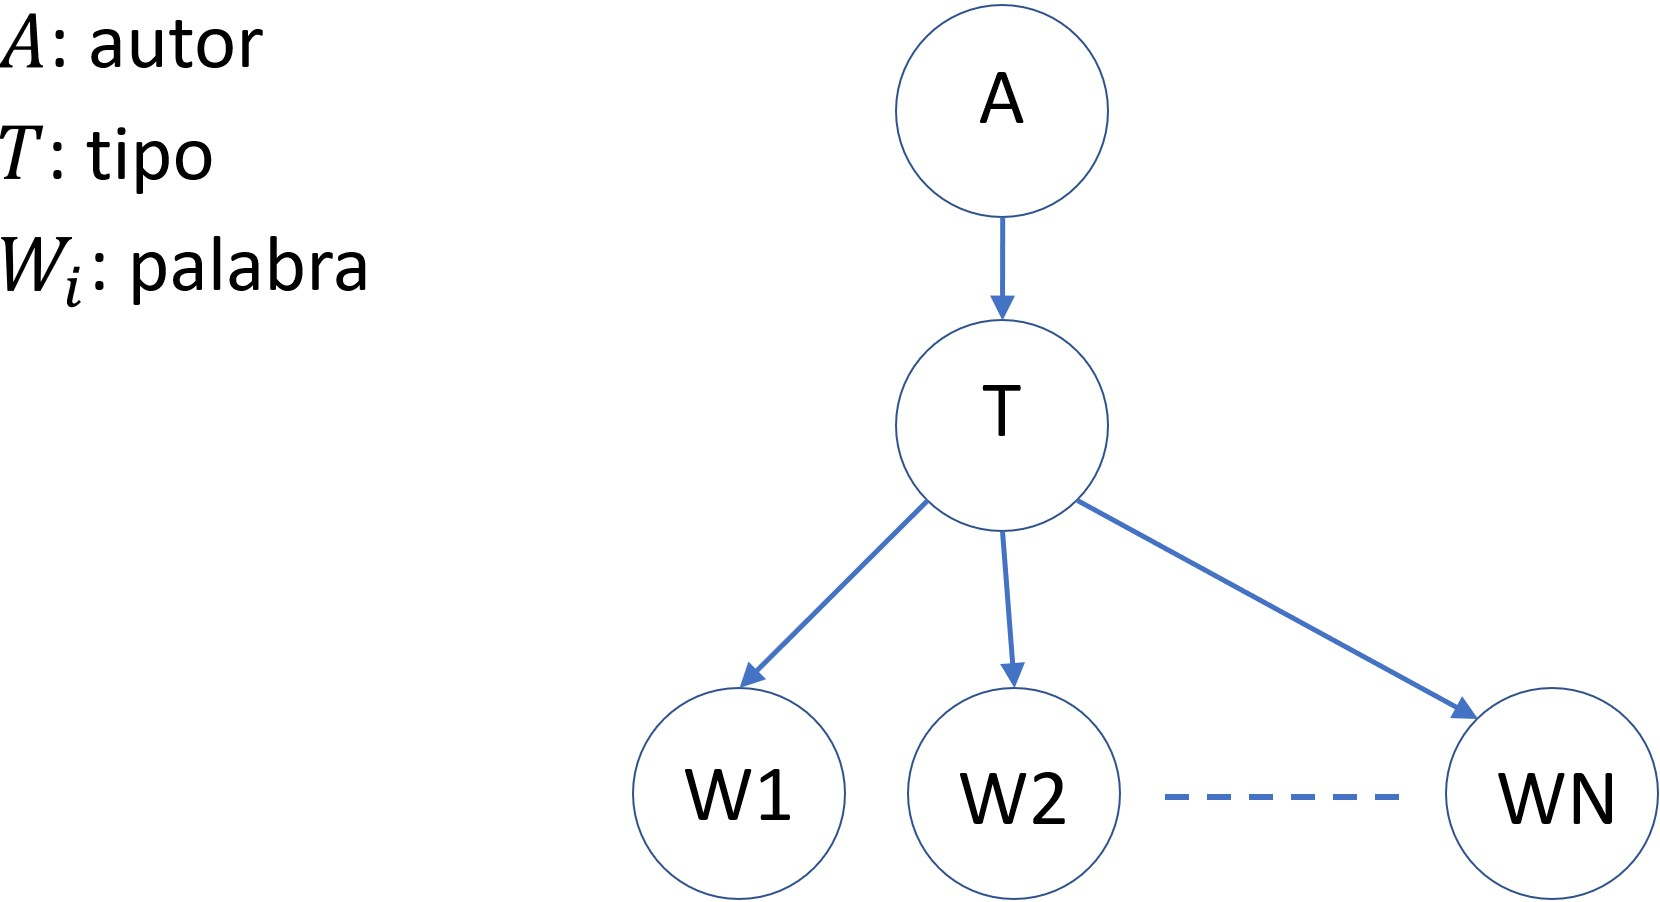

### $P(A)P(T|A)\prod_{i=1}^N P(W_i|T)$

## Variables

### Conteo de autores y tipos de cuento

In [ ]:
# Ocurrencias de cada autor y conteos de ocurrencias y de número de autores
oc_autor = Counter(df_train_T.autor)
tot_oc_aut = np.sum(list(oc_autor.values()))
tot_autores = len(oc_autor)

print('{0} autores en total: {1}'.format(tot_autores,list(oc_autor.values())))
print('{} menciones totales'.format(tot_oc_aut))

# Ocurrencias de cada tipo y conteos de ocurrencias y de número de tipos
oc_tipo = Counter(df_train_T.tipo)
tot_oc_tipo = np.sum(list(oc_tipo.values()))
tot_tipos = len(oc_tipo)

print('{0} tipos de cuento en total: {1}'.format(tot_tipos,list(oc_tipo.values())))
print('{} menciones totales'.format(tot_oc_tipo))

10 autores en total: [2, 2, 2, 2, 5, 4, 4, 4, 3, 2]
30 menciones totales
3 tipos de cuento en total: [13, 14, 3]
30 menciones totales


### Definición de variables MIB

#### **Nota Importante**
* Por ahora, el motor de inferencia sólo acepta valores numéricos como valores posibles de una variable.
* Por lo tanto, vamos a crear un mapeo entre los nombres de los autores y un valor entero mediante un diccionario.
* También creamos un mapeo inverso, para poder recuperar las etiquetas a partir de los enteros.
* Haremos lo mismo con los tipos.

In [ ]:
"""
Autor
"""
print("\nAutor\n")
#diccionario autor->valor
autor_val = dict(zip(oc_autor.keys(),range(len(oc_autor.keys()))))
#diccionario valor->autor
val_autor = dict(zip(range(len(oc_autor.keys())),oc_autor.keys()))
print(autor_val)
print(val_autor)
A=mb.Var('A')
A.set_values(range(len(autor_val)))
print(A.print_var())

"""
Tipo
"""
print("\nTipo\n")
#diccionario autor->valor
tipo_val = dict(zip(oc_tipo.keys(),range(len(oc_tipo.keys()))))
#diccionario valor->autor
val_tipo = dict(zip(range(len(oc_tipo.keys())),oc_tipo.keys()))
print(tipo_val)
print(val_tipo)
T=mb.Var('T')
T.set_values(range(len(tipo_val)))
print(T.print_var())



"""
Palabras
"""
#print("\nPalabras en Train\n")

vocabularioTrain=vTR
WTr = {}
for i,w in enumerate(vocabularioTrain):
    WTr[i] = {w:mb.Var(name='WTr'+str(i),values=[0,1])}

for i in range(len(WTr)):
    print(f'WTr[{i}]: {WTr[i]}')

#print("\nPalabras en test\n")
#vocabularioTest=vTS
#WTs = {}
#for i,w in enumerate(vocabularioTest):
    #WTs[i] = {w:mb.Var(name='WTs'+str(i),values=[0,1])}

#for i in range(len(WTs)):
    #print(f'WTs[{i}]: {WTs[i]}')
#Palabras, presente:1 ausente:0
#Se crean de manera similar a como se hizo para el filtro SPAM



Autor

{'horacio quiroga': 0, 'josé saramago': 1, 'juan rulfo': 2, 'carlos fuentes': 3, 'gibrán jalil gibrán': 4, 'jean de la fontaine': 5, 'gabriel garcía márquez': 6, 'alfonso reyes': 7, 'esopo': 8, 'juan carlos onetti': 9}
{0: 'horacio quiroga', 1: 'josé saramago', 2: 'juan rulfo', 3: 'carlos fuentes', 4: 'gibrán jalil gibrán', 5: 'jean de la fontaine', 6: 'gabriel garcía márquez', 7: 'alfonso reyes', 8: 'esopo', 9: 'juan carlos onetti'}
('A', 10, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Tipo

{'cuento': 0, 'minicuento': 1, 'fábula': 2}
{0: 'cuento', 1: 'minicuento', 2: 'fábula'}
('T', 3, [0, 1, 2])
WTr[0]: {'alicia': <mib.Var object at 0x7f7ffbb25210>}
WTr[1]: {'jordán': <mib.Var object at 0x7f7ffbb25fd0>}
WTr[2]: {'día': <mib.Var object at 0x7f7ffbb25290>}
WTr[3]: {'cama': <mib.Var object at 0x7f7ffba0f650>}
WTr[4]: {'largo': <mib.Var object at 0x7f7ffba0fa90>}
WTr[5]: {'entonces': <mib.Var object at 0x7f7ffbb16910>}
WTr[6]: {'mujer': <mib.Var object at 0x7f7ffbb16a10>}
WTr[7]: {'maría':

Descomposición

Autores

In [ ]:
conteos_autores= list(oc_autor.values())
probabilidadAutores=[]

for i in range(len(conteos_autores)):
  result=(conteos_autores[i]+1)/(tot_oc_aut+ len(oc_autor)) #Por correccion de laplace 
  probabilidadAutores.append(result)

PA=mb.Distrib('P(A)',[A],probabilidadAutores)
PA._print()


Printing:  P(A)
('A', 0):0.075  ('A', 1):0.075  ('A', 2):0.075  ('A', 3):0.075  ('A', 4):0.15  ('A', 5):0.125  ('A', 6):0.125  ('A', 7):0.125  ('A', 8):0.1  ('A', 9):0.075  



In [ ]:
df=PA.to_Frame()
df

Creating DataFrame for:  P(A)


,P(A)
"(A, 0)",0.075
"(A, 1)",0.075
"(A, 2)",0.075
"(A, 3)",0.075
"(A, 4)",0.150
"(A, 5)",0.125
"(A, 6)",0.125
"(A, 7)",0.125
"(A, 8)",0.100
"(A, 9)",0.075


Tipo dado autores

In [ ]:
df1=df_train_T.groupby(['autor','tipo']).count().reindex()
df2=df1.iloc[:, 0].to_dict()
print(df2)

{('alfonso reyes', 'minicuento'): 4, ('carlos fuentes', 'cuento'): 1, ('carlos fuentes', 'minicuento'): 1, ('esopo', 'fábula'): 3, ('gabriel garcía márquez', 'cuento'): 1, ('gabriel garcía márquez', 'minicuento'): 3, ('gibrán jalil gibrán', 'cuento'): 4, ('gibrán jalil gibrán', 'minicuento'): 1, ('horacio quiroga', 'cuento'): 2, ('jean de la fontaine', 'minicuento'): 4, ('josé saramago', 'cuento'): 1, ('josé saramago', 'minicuento'): 1, ('juan carlos onetti', 'cuento'): 2, ('juan rulfo', 'cuento'): 2}


In [ ]:
autores = list(set(df_train_T.autor))
print(autores)
tipos = list(set(df_train_T.tipo))
print(tipos)
au_tipo = product(autores,tipos)
print(au_tipo)

['gibrán jalil gibrán', 'alfonso reyes', 'esopo', 'jean de la fontaine', 'juan carlos onetti', 'juan rulfo', 'carlos fuentes', 'horacio quiroga', 'gabriel garcía márquez', 'josé saramago']
['fábula', 'cuento', 'minicuento']


In [ ]:
print(len(tipo_val))
count_autor_tipo={}

for k in df2.keys():
  if(k[0] in count_autor_tipo):
    count_autor_tipo[k[0]]=count_autor_tipo[k[0]]+df2[k]
  else:
    count_autor_tipo[k[0]]=df2[k]
print(count_autor_tipo)

3
{'alfonso reyes': 4, 'carlos fuentes': 2, 'esopo': 3, 'gabriel garcía márquez': 4, 'gibrán jalil gibrán': 5, 'horacio quiroga': 2, 'jean de la fontaine': 4, 'josé saramago': 2, 'juan carlos onetti': 2, 'juan rulfo': 2}


In [ ]:

dT_A = {}
for a, t in au_tipo:
    par = (a,t)
    autor_valor = autor_val[a]
    if autor_valor in dT_A.keys():
        if par in df2.keys():
            dT_A[autor_valor][tipo_val[t]]=(df2[par]+1)/(len(tipo_val)+count_autor_tipo[a])
        else:
            dT_A[autor_valor][tipo_val[t]]=(0+1)/(len(tipo_val)+count_autor_tipo[a])
    else:
        if par in df2.keys():
            dT_A[autor_valor]={tipo_val[t]:(df2[par]+ 1)/(len(tipo_val)+count_autor_tipo[a])}
        else:
            dT_A[autor_valor]={tipo_val[t]:(0+1)/(len(tipo_val)+count_autor_tipo[a])}

print(dT_A)

{4: {2: 0.125, 0: 0.625, 1: 0.25}, 7: {2: 0.14285714285714285, 0: 0.14285714285714285, 1: 0.7142857142857143}, 8: {2: 0.6666666666666666, 0: 0.16666666666666666, 1: 0.16666666666666666}, 5: {2: 0.14285714285714285, 0: 0.14285714285714285, 1: 0.7142857142857143}, 9: {2: 0.2, 0: 0.6, 1: 0.2}, 2: {2: 0.2, 0: 0.6, 1: 0.2}, 3: {2: 0.2, 0: 0.4, 1: 0.4}, 0: {2: 0.2, 0: 0.6, 1: 0.2}, 6: {2: 0.14285714285714285, 0: 0.2857142857142857, 1: 0.5714285714285714}, 1: {2: 0.2, 0: 0.4, 1: 0.4}}


In [ ]:
PT_A=mb.DistribCond('P(T|A)',[T],[A],dT_A)
PT_A._print()

Printing:  P(T|A)
('A', 0):{('T', 0): 0.625, ('T', 1): 0.25, ('T', 2): 0.125}  ('A', 1):{('T', 0): 0.14285714285714285, ('T', 1): 0.7142857142857143, ('T', 2): 0.14285714285714285}  ('A', 2):{('T', 0): 0.16666666666666666, ('T', 1): 0.16666666666666666, ('T', 2): 0.6666666666666666}  ('A', 3):{('T', 0): 0.14285714285714285, ('T', 1): 0.7142857142857143, ('T', 2): 0.14285714285714285}  ('A', 4):{('T', 0): 0.6, ('T', 1): 0.2, ('T', 2): 0.2}  ('A', 5):{('T', 0): 0.6, ('T', 1): 0.2, ('T', 2): 0.2}  ('A', 6):{('T', 0): 0.4, ('T', 1): 0.4, ('T', 2): 0.2}  ('A', 7):{('T', 0): 0.6, ('T', 1): 0.2, ('T', 2): 0.2}  ('A', 8):{('T', 0): 0.2857142857142857, ('T', 1): 0.5714285714285714, ('T', 2): 0.14285714285714285}  ('A', 9):{('T', 0): 0.4, ('T', 1): 0.4, ('T', 2): 0.2}  



In [ ]:
df=PT_A.to_Frame()
df
#np.sum(df.values)

,"(T, 0)","(T, 1)","(T, 2)"
"(A, 0)",0.625000,0.250000,0.125000
"(A, 1)",0.142857,0.714286,0.142857
"(A, 2)",0.166667,0.166667,0.666667
"(A, 3)",0.142857,0.714286,0.142857
"(A, 4)",0.600000,0.200000,0.200000
"(A, 5)",0.600000,0.200000,0.200000
"(A, 6)",0.400000,0.400000,0.200000
"(A, 7)",0.600000,0.200000,0.200000
"(A, 8)",0.285714,0.571429,0.142857
"(A, 9)",0.400000,0.400000,0.200000


Palabra dado tipo 

In [ ]:
vocabulario=[]
for j in range(5):
  for i in range(len(df_tr['w'+str(j)])):
    vocabulario.append(df_tr['w0'][i])

print(vocabulario)
print(len(vocabulario))

['alicia', 'entonces', 'muchacho', 'café', 'acuérdate', 'llano', 'solo', 'chac', 'hierba', 'vino', 'príncipe', 'poeta', 'dos', 'perro', 'cien', 'casa', 'león', 'calle', 'bote', 'fantasma', 'niño', 'alivios', 'vida', 'catástrofe', 'gobernante', 'águila', 'liebre', 'águila', 'hombre', 'pelota', 'alicia', 'entonces', 'muchacho', 'café', 'acuérdate', 'llano', 'solo', 'chac', 'hierba', 'vino', 'príncipe', 'poeta', 'dos', 'perro', 'cien', 'casa', 'león', 'calle', 'bote', 'fantasma', 'niño', 'alivios', 'vida', 'catástrofe', 'gobernante', 'águila', 'liebre', 'águila', 'hombre', 'pelota', 'alicia', 'entonces', 'muchacho', 'café', 'acuérdate', 'llano', 'solo', 'chac', 'hierba', 'vino', 'príncipe', 'poeta', 'dos', 'perro', 'cien', 'casa', 'león', 'calle', 'bote', 'fantasma', 'niño', 'alivios', 'vida', 'catástrofe', 'gobernante', 'águila', 'liebre', 'águila', 'hombre', 'pelota', 'alicia', 'entonces', 'muchacho', 'café', 'acuérdate', 'llano', 'solo', 'chac', 'hierba', 'vino', 'príncipe', 'poeta', '

In [ ]:
dictred = OrderedDict(zip(vocabulario,range(len(vocabulario))))
v = list(dictred.keys())
i=0
while i<10:
    print(v[i], end=', ')
    i+=1

alicia, entonces, muchacho, café, acuérdate, llano, solo, chac, hierba, vino, 

In [ ]:
def pares_au_tipo(au_tipo):
    at_dict = {}
    for par in au_tipo:
        autor,tipo = par
        at_dict[par] = (autor_val[autor],tipo_val[tipo])
    return at_dict

pares_TA=pares_au_tipo(au_tipo)
print(pares_TA)

{('gibrán jalil gibrán', 'fábula'): (4, 2), ('gibrán jalil gibrán', 'cuento'): (4, 0), ('gibrán jalil gibrán', 'minicuento'): (4, 1), ('alfonso reyes', 'fábula'): (7, 2), ('alfonso reyes', 'cuento'): (7, 0), ('alfonso reyes', 'minicuento'): (7, 1), ('esopo', 'fábula'): (8, 2), ('esopo', 'cuento'): (8, 0), ('esopo', 'minicuento'): (8, 1), ('jean de la fontaine', 'fábula'): (5, 2), ('jean de la fontaine', 'cuento'): (5, 0), ('jean de la fontaine', 'minicuento'): (5, 1), ('juan carlos onetti', 'fábula'): (9, 2), ('juan carlos onetti', 'cuento'): (9, 0), ('juan carlos onetti', 'minicuento'): (9, 1), ('juan rulfo', 'fábula'): (2, 2), ('juan rulfo', 'cuento'): (2, 0), ('juan rulfo', 'minicuento'): (2, 1), ('carlos fuentes', 'fábula'): (3, 2), ('carlos fuentes', 'cuento'): (3, 0), ('carlos fuentes', 'minicuento'): (3, 1), ('horacio quiroga', 'fábula'): (0, 2), ('horacio quiroga', 'cuento'): (0, 0), ('horacio quiroga', 'minicuento'): (0, 1), ('gabriel garcía márquez', 'fábula'): (6, 2), ('gabr

In [ ]:
conteo_w = dict(df_train_T2.conteos)
pares_train = list(zip(df_train_T.autor,df_train_T.tipo))
print(conteo_w)
print(pares_train)

{7: {'chac': 32, 'mool': 28, 'agua': 11, 'filiberto': 10, 'hoy': 10, 'día': 9, 'casa': 9, 'sótano': 9, 'vida': 8, 'piedra': 8, 'tan': 7, 'noche': 7, 'luz': 7, 'sólo': 7, 'aquí': 7, 'allí': 7, 'dos': 7, 'pensión': 6, 'ser': 6, 'ver': 6, 'fin': 6, 'hace': 5, 'ahora': 5, 'natural': 5, 'oficina': 5, 'casi': 5, 'poder': 5, 'pepe': 5, 'parece': 5, 'dios': 5, 'parecía': 5, 'real': 5, 'puerta': 5, 'tiempo': 4, 'años': 4, 'mientras': 4, 'pesos': 4, 'méxico': 4, 'mismo': 4, 'nunca': 4, 'podía': 4, 'hecho': 4, 'todas': 4, 'dar': 4, 'lagunilla': 4, 'escultura': 4, 'lluvias': 4, 'cada': 4, 'veces': 4, 'días': 4, 'luego': 4, 'dormir': 4, 'acapulco': 3, 'bien': 3, 'müller': 3, 'cierto': 3, 'amigo': 3, 'quizá': 3, 'entonces': 3, 'hacia': 3, 'compañeros': 3, 'volví': 3, 'fuente': 3, 'pretendí': 3, 'mano': 3, 'algún': 3, 'recuerdo': 3, 'muerte': 3, 'cosa': 3, 'toda': 3, 'hombres': 3, 'fines': 3, 'domingo': 3, 'debido': 3, 'director': 3, 'risa': 3, 'oscuridad': 3, 'tubería': 3, 'terrible': 3, 'pensé': 3,

In [ ]:
for i,k in enumerate(conteo_w.keys()):
    conteo_w[k] = {pares_train[i] : dict(conteo_w[k])}

print(conteo_w)

{7: {('horacio quiroga', 'cuento'): {'chac': 32, 'mool': 28, 'agua': 11, 'filiberto': 10, 'hoy': 10, 'día': 9, 'casa': 9, 'sótano': 9, 'vida': 8, 'piedra': 8, 'tan': 7, 'noche': 7, 'luz': 7, 'sólo': 7, 'aquí': 7, 'allí': 7, 'dos': 7, 'pensión': 6, 'ser': 6, 'ver': 6, 'fin': 6, 'hace': 5, 'ahora': 5, 'natural': 5, 'oficina': 5, 'casi': 5, 'poder': 5, 'pepe': 5, 'parece': 5, 'dios': 5, 'parecía': 5, 'real': 5, 'puerta': 5, 'tiempo': 4, 'años': 4, 'mientras': 4, 'pesos': 4, 'méxico': 4, 'mismo': 4, 'nunca': 4, 'podía': 4, 'hecho': 4, 'todas': 4, 'dar': 4, 'lagunilla': 4, 'escultura': 4, 'lluvias': 4, 'cada': 4, 'veces': 4, 'días': 4, 'luego': 4, 'dormir': 4, 'acapulco': 3, 'bien': 3, 'müller': 3, 'cierto': 3, 'amigo': 3, 'quizá': 3, 'entonces': 3, 'hacia': 3, 'compañeros': 3, 'volví': 3, 'fuente': 3, 'pretendí': 3, 'mano': 3, 'algún': 3, 'recuerdo': 3, 'muerte': 3, 'cosa': 3, 'toda': 3, 'hombres': 3, 'fines': 3, 'domingo': 3, 'debido': 3, 'director': 3, 'risa': 3, 'oscuridad': 3, 'tubería

In [ ]:
def check(wtr,tipo_autor):
    pw_ = {}
    word = list(wtr.keys())[0]
    var = wtr[word]
    #print(var)
    pares = pares_au_tipo(tipo_autor)
    for par in pares:
        i = 0 
        cw_1 = 0   
        cw_0 = 0    
        for palabras_conteo in list(conteo_w.values()):  
            i += 1
            if par in palabras_conteo: 
                if word in list(palabras_conteo.values())[0]: 
                    cw_1 += 1
                else:
                    cw_0 += 1  
        if cw_0 == cw_1: 
            pw_1 = 0.5   
            pw_0 = 0.5
        else:
            pw_1=(1+cw_1)/(var.card+i) #Por correcion de LaPlace
            pw_0 = 1-pw_1
        pw_[pares[par]]=[pw_0,pw_1]
    pw_ = OrderedDict(sorted(pw_.items()))
    return pw_

In [ ]:
PW_AT=[]
for w in vTR: 
    i = vTR[w]
    t = check(WTr[i],pares_TA)
    var=WTr[i][list(vTR.keys())[i]]
    #print(i," ",list(vTR.keys())[i])
    PW_AT.append(mb.DistribCond(name='P(W'+str(i)+'|AT)',var=var,indep=[A,T],tabla=t))

In [ ]:
vTR['lobo']

64

In [ ]:
print(PW_AT[vTR['lobo']].name,'\n',PW_AT[vTR['lobo']].to_Frame(),'\n')

P(W64|AT) 
              (WTr64, 0) (WTr64, 1)
(A, T, 0, 0)    0.96875    0.03125
(A, T, 0, 1)    0.50000    0.50000
(A, T, 0, 2)    0.50000    0.50000
(A, T, 1, 0)    0.96875    0.03125
(A, T, 1, 1)    0.96875    0.03125
(A, T, 1, 2)    0.50000    0.50000
(A, T, 2, 0)    0.96875    0.03125
(A, T, 2, 1)    0.50000    0.50000
(A, T, 2, 2)    0.50000    0.50000
(A, T, 3, 0)    0.96875    0.03125
(A, T, 3, 1)    0.96875    0.03125
(A, T, 3, 2)    0.50000    0.50000
(A, T, 4, 0)    0.93750    0.06250
(A, T, 4, 1)    0.96875    0.03125
(A, T, 4, 2)    0.50000    0.50000
(A, T, 5, 0)    0.50000    0.50000
(A, T, 5, 1)    0.96875    0.03125
(A, T, 5, 2)    0.50000    0.50000
(A, T, 6, 0)    0.96875    0.03125
(A, T, 6, 1)    0.96875    0.03125
(A, T, 6, 2)    0.50000    0.50000
(A, T, 7, 0)    0.50000    0.50000
(A, T, 7, 1)    0.93750    0.06250
(A, T, 7, 2)    0.50000    0.50000
(A, T, 8, 0)    0.50000    0.50000
(A, T, 8, 1)    0.50000    0.50000
(A, T, 8, 2)    0.96875    0.03125
(A, T, 9

In [ ]:
len(WTr)

136

## Identificación de parámetros (estadísticas)

#1. ¿Quién escribió "El caballo y el Lobo"?

La pregunta que le debemos hacer al motor de inferencia es:

$$P(A|W = \{'caballo', 'lobo'\})$$

Para esto, debemos construir la conjunta de las 3 variables:

$$P(ATW^n_1)= P(A) P(T|A) \prod^n_1 P(W_i|AT)$$

La pregunta tambien se puede descomponer de la siguiente forma:

$$P(A|W = \{'caballo', 'lobo'\})=\frac{P(A, 'caballo', 'lobo')}{P('caballo','lobo')}$$

Donde P(A, 'caballo', 'lobo') se puede expresar como:

$$P(A, 'caballo', 'lobo')= \sum_{T,\left\{ W_1, ..., Wn\right\}\setminus \left\{'caballo', 'lobo' \right\}} P(ATW_{1}^{n})$$

Y P('caballo','lobo') como:

$$P('caballo','lobo')= \sum_{T,A,\left\{ W_1, ..., Wn\right\}\setminus \left\{'caballo', 'lobo' \right\}} P(ATW_{1}^{n})$$

Como los calculos para hacer la conjunta de las 3 variables involucra una gran cantidad de operaciones, realizamos un muestreo aleatorio de la cantidad de palabras en el cuento "El caballo y el lobo" en conjunto con palabras del vocabulario de  enntrenamiento para obtener un valor aproximado.

In [ ]:
#1¿Quién escribió "El caballo y el Lobo"?
#print(PA.get_P(('A',0)))
Pa_w=[]
D=0
for a in autor_val:
  N=0
  pwta4=1
  for t in tipo_val:
    pa=PA.get_P(('A',autor_val[a]))
    pta=PT_A.get_P([('A',autor_val[a])])
    pta2=pta[0][('T',tipo_val[t])]
    pwta3=1
    for w in vTR:
        pwta= PW_AT[vTR[w]].get_P([('A','T',autor_val[a],tipo_val[t])])
        pwta_0=pwta[0][('WTr'+str(vTR[w]),0)]
        pwta_1=pwta[0][('WTr'+str(vTR[w]),1)]
        

#2. "La escopeta" ¿es una fábula?
De manera similar a la pregunta anterior: 
$$P(T=\{2\}|W = \{'Escopeta'\})$$

La pregunta tambien se puede descomponer de la siguiente forma:

$$P(T=\{2\}|W = \{'escopeta'\})=\frac{P(T=2, W='escopeta')}{P(W='escopeta')}$$

Donde P(T=2, W='escopeta') se puede expresar como:


$$P(T=2, W='escopeta')= \sum_{A,T=\{1,2\},\left\{ W_1, ..., Wn\right\}\setminus \left\{'escopeta' \right\}} P(ATW_{1}^{n})$$

Y P(W='escopeta') como:

$$P(W='escopeta')= \sum_{T,A,\left\{ W_1, ..., Wn\right\}\setminus \left\{'escopeta' \right\}} P(ATW_{1}^{n})$$

P(W='escopeta') tambien se puede encontrar facilmente evaluando en PW_AT[vTR['escopeta']].

In [ ]:
print(val_tipo[2])

In [ ]:
#2"La escopeta" ¿es una fábula?

#3. ¿Qué probabilidad hay de que "La muerte" haya sido escrita por José Saramago
De manera similar a las preguntas anteriores:
$$P(A=\{'Jose Saramago'\}|W = \{'muerte'\})$$

Tambien se puede descomponer de la siguiente forma:

$$P(A=\{'Jose Saramago'\}|W = \{'muerte'\})=\frac{P(A='Jose Saramago', 'muerte')}{P('muerte')}$$

Donde P(A='Jose Saramago', 'muerte') se puede expresar como:

$$P(A='Jose Saramago', 'muerte')= \sum_{A ∖ 'Jose Saramago', T, \left\{ W_1, ..., Wn\right\}\setminus \left\{'muerte' \right\}} P(ATW_{1}^{n})$$

Y P('muerte') como:

$$P('muerte')= \sum_{T,A,\left\{ W_1, ..., Wn\right\}\setminus \left\{'muerte'\right\}} P(ATW_{1}^{n})$$

In [ ]:
#3¿Qué probabilidad hay de que "La muerte" haya sido escrita por José Saramago

#4¿Pudo "La marcha del caracol" haber sido escrita por García Márquez y Fuentes en co-autoría?

La pregunta que le debemos hacer al motor de inferencia es:

$$P(A=\{'Garcia Marquez', 'Fuentes'\}|W = \{'marcha', 'caracol', 'del'\})$$

Tambien se puede descomponer de la siguiente forma:

$$P(A=\{'Garcia Marquez', 'Fuentes'\}|W = \{'marcha', 'caracol', 'del'\})=\frac{P(A='Garcia Marquez', A='Fuentes', 'marcha','caracol', 'del' )}{P(W = \{'marcha', 'caracol', 'del'\})}$$

Donde P(A='Garcia Marquez', A='Fuentes', 'marcha','caracol', 'del' ) se puede expresar como:

$$P(A='Garcia Marquez', A='Fuentes', 'marcha','caracol', 'del' )= \sum_{A ∖\left\{ 'Garcia Marquez', 'Fuentes'\right\}, T, \left\{ W_1, ..., Wn\right\}\setminus \left\{'marcha','caracol', 'del' \right\}} P(ATW_{1}^{n})$$

Y P(W = \{'marcha', 'caracol', 'del'\}) como:

$$P(W = \{'marcha', 'caracol', 'del'\})= \sum_{T,A,\left\{ W_1, ..., Wn\right\}\setminus \left\{'marcha','caracol', 'del'\right\}} P(ATW_{1}^{n})$$

In [ ]:
#4¿Pudo "La marcha del caracol" haber sido escrita por García Márquez y Fuentes en co-autoría?

#5. Dado que "El águila de ala cortada y la zorra" es una fábula, ¿qué probabilidad hay de que haya sido escrita por Jalil Gibrán?

La pregunta que le debemos hacer al motor de inferencia es:

$$P(A=′Jalil Gibran′ |T=2,W=\{'aguila', 'ala', 'cortada', 'zorra'\})$$

Tambien se puede descomponer de la siguiente forma:

$$P(A=′Jalil Gibran′ |T=2,W=\{'aguila', 'ala', 'cortada', 'zorra'\})=\frac{P(A=′Jalil Gibran′, T=2,'aguila', 'ala', 'cortada', 'zorra' )}{P(T=2, 'aguila', 'ala', 'cortada', 'zorra')}$$

Donde P(A=′Jalil Gibran′, T=2,'aguila', 'ala', 'cortada', 'zorra' ) se puede expresar como:

$$P(A=′Jalil Gibran′, T=2,'aguila', 'ala', 'cortada', 'zorra' )= \sum_{A ∖ 'Jalil Gibran', T \setminus 2, \left\{ W_1, ..., Wn\right\}\setminus \left\{'aguila', 'ala', 'cortada', 'zorra' \right\}} P(ATW_{1}^{n})$$

Y P(T=2, 'aguila', 'ala', 'cortada', 'zorra') como:

$$P(T=2, 'aguila', 'ala', 'cortada', 'zorra')= \sum_{T ∖ 2,A,\left\{ W_1, ..., Wn\right\}\setminus \left\{'aguila', 'ala', 'cortada', 'zorra'\right\}} P(ATW_{1}^{n})$$

In [ ]:
#5 Dado que "El águila de ala cortada y la zorra" es una fábula, ¿qué probabilidad hay de que haya sido escrita por Jalil Gibrán?

#6. ¿Qué proporción hay de minicuentos?
La pregunta que le debemos hacer al motor de inferencia es:

$$P(T=1)$$

Descomposicion:

$$P(T=1)= \sum_{T ∖1,A,\left\{ W_1, ..., Wn\right\}} P(ATW_{1}^{n})$$
 


In [ ]:
#6 ¿Qué proporción hay de minicuentos?

#7. ¿Qué cuentos son de Carlos Onetti?

La pregunta que le debemos hacer al motor de inferencia es:

$$P(T=0 |A='Carlos Onetti')$$

Descomposicion:


$$P(T=0 |A='Carlos Onetti')=\frac{P(T=0, A='Carlos Onetti')}{P(A='Carlos Onetti')}$$

Donde P(T=0, A='Carlos Onetti') se puede expresar como:

$$P(T=0, A='Carlos Onetti')= \sum_{A \setminus 'Carlos Onetti' ,T \setminus 0,\left\{ W_1, ..., Wn\right\}} P(ATW_{1}^{n})$$

Y P('caballo','lobo') como:

$$P(A='Carlos Onetti')= \sum_{T,A \setminus 'Carlos Onetti',\left\{ W_1, ..., Wn\right\}} P(ATW_{1}^{n})$$

In [ ]:
#7¿Qué cuentos son de Carlos Onetti?


#8. ¿Quién dijo: "Desde que abrí los ojos me di cuenta que mi sitio no estaba aquí, donde yo estoy, sino en donde no estoy ni he estado nunca. En alguna parte hay un lugar vacío y ese vacío se llenará de mí y yo me asentaré en ese hueco que insensiblemente rebosará de mí, pleno de mí hasta volverse fuente o surtidor. Y mi vacío, el vacío de mí que soy ahora, se llenará de sí, pleno de sí, pleno de ser hasta los bordes."?

La pregunta que le debemos hacer al motor de inferencia es:

$$P(A|W=\{'Desde', 'que', 'abrí', 'ojos', ..., 'hasta', 'bordes'\})$$

Descomposicion:

$$P(A|W=\{'Desde', 'que', 'abrí', 'ojos', ..., 'hasta', 'bordes'\})=\frac{P(A, 'Desde', 'que', 'abrí', 'ojos', ..., 'hasta', 'bordes')}{P('Desde', 'que', 'abrí', 'ojos', ..., 'hasta', 'bordes')}$$

Donde P(A, 'Desde', 'que', 'abrí', 'ojos', ..., 'hasta', 'bordes') se puede expresar como:

$$P(A, 'Desde', 'que', 'abrí', 'ojos', ..., 'hasta', 'bordes')= \sum_{T,\left\{ W_1, ..., Wn\right\}\setminus \left\{'Desde', 'que', 'abrí', 'ojos', ..., 'hasta', 'bordes'\right\}} P(ATW_{1}^{n})$$

Y P('caballo','lobo') como:

$$P('Desde', 'que', 'abrí', 'ojos', ..., 'hasta', 'bordes')= \sum_{T,A,\left\{ W_1, ..., Wn\right\}\setminus \left\{'Desde', 'que', 'abrí', 'ojos', ..., 'hasta', 'bordes'\right\}} P(ATW_{1}^{n})$$



In [ ]:
#8¿Quién dijo: "Desde que abrí los ojos me di cuenta que mi sitio no estaba aquí, donde yo estoy, sino en donde no estoy ni he estado nunca. En alguna parte hay un lugar vacío y ese vacío se llenará de mí y yo me asentaré en ese hueco que insensiblemente rebosará de mí, pleno de mí hasta volverse fuente o surtidor. Y mi vacío, el vacío de mí que soy ahora, se llenará de sí, pleno de sí, pleno de ser hasta los bordes."?


#9. ¿Quién es el autor con más cuentos?

La pregunta que le debemos hacer al motor de inferencia es:

$$max(P(A|T=0))$$

Descomposicion:

$$P(A|T=0)=\frac{P(A, T=0)}{P(T=0)}$$

Donde P(A, T=0) se puede expresar como:

$$P(A, T=0)= \sum_{T ∖ 0,\left\{ W_1, ..., Wn\right\}} P(ATW_{1}^{n})$$

Y P(T=0) como:

$$P(T=0)= \sum_{T ∖0,A,\left\{ W_1, ..., Wn\right\}} P(ATW_{1}^{n})$$



In [ ]:
#9¿Quién es el autor con más cuentos?


#10. ¿Qué probablidad hay de quien haya escrito "Retiniblastoma" haya también escrito "El sol y las ranas"?

La pregunta que deberiamos hacer al motor de inferencia es:

$$P(A|W=\{'retiniblastoma', 'sol', 'ranas', 'y'\})$$

Esto debido a que en nuestro modelo no tomamos en cuenta el titulo del texto.

$$P(A|W=\{'retiniblastoma', 'sol', 'ranas', 'y'\})=\frac{P(A, 'retiniblastoma', 'sol', 'ranas', 'y')}{P('retiniblastoma', 'sol', 'ranas', 'y')}$$

Donde P(A, 'retiniblastoma', 'sol', 'ranas', 'y') se puede expresar como:

$$P(A, 'retiniblastoma', 'sol', 'ranas', 'y')= \sum_{T,\left\{ W_1, ..., Wn\right\}\setminus \left\{'retiniblastoma', 'sol', 'ranas', 'y'\right\}} P(ATW_{1}^{n})$$

Y P('retiniblastoma', 'sol', 'ranas', 'y') como:

$$P('retiniblastoma', 'sol', 'ranas', 'y')= \sum_{T,A,\left\{ W_1, ..., Wn\right\}\setminus \left\{'retiniblastoma', 'sol', 'ranas', 'y'\right\}} P(ATW_{1}^{n})$$

In [ ]:
#10¿Qué probablidad hay de quien haya escrito "Retiniblastoma" haya también escrito "El sol y las ranas"?